In [16]:
import os
import torch
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from dataset import DFUDataset
from loss import DiceLoss, BCEWithLogitsLoss, IOU
from optimiser import SGD, Adam
from model import UNet, DeepLabV3_MobileNet_V3_Large
from readFiles import ReadFiles
from training import Train
import numpy as np

import matplotlib as mpl 
import matplotlib.pyplot as plt 
import seaborn as sns

def ReadDirectories():
    print("Reading files from directories.")
    data_path = ""
    # Set training directory
    train_dir = os.path.join(data_path, "dfuc2022/train/images")
    train_mask_dir = os.path.join(data_path, "dfuc2022//train/masks")

    # Set validation directory
    val_dir = os.path.join(data_path, "dfuc2022/val/images")
    val_mask_dir = os.path.join(data_path, "dfuc2022/val/masks")

    # Set test directory
    test_dir = os.path.join(data_path, "dfuc2022/test/")

    train_files = ReadFiles(train_dir)
    train_masks = ReadFiles(train_mask_dir)

    val_files = ReadFiles(val_dir)
    val_masks = ReadFiles(val_mask_dir)

    test_files = ReadFiles(test_dir)
    print("Complete.")

    return train_files, train_masks, val_files, val_masks, test_files

def Transforms():
    transform_train = A.Compose([
        #A.augmentations.dropout.cutout.Cutout(num_holes=8, max_h_size=8, max_w_size=8, fill_value=0, always_apply=False, p=0.5),
        #A.HorizontalFlip(p=0.5),
        #A.VerticalFlip(p=0.5),
        #A.RandomBrightnessContrast(p=0.2),
        #ToTensorV2(),
        #A.augmentations.transforms.GaussNoise(var_limit=(10.0, 50.0), mean=0, per_channel=True, always_apply=False, p=0.5),
        #A.augmentations.geometric.transforms.ShiftScaleRotate(
        #    shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, interpolation=1, p=0.5),
        ToTensorV2(),
    ])

    transform_test = A.Compose([
        ToTensorV2(),
    ])

    return transform_train, transform_test


# Read directories into file lists.
train_files, train_masks, val_files, val_masks, test_files = ReadDirectories()

# Get transformations from Transforms()
transform_train, transform_test = Transforms()

# Generate manual seed for reproducability
torch.manual_seed(42)

# Load dataset
print("Loading datasets...")
train_ds = DFUDataset(train_files, train_masks, transform=transform_train)
val_ds = DFUDataset(val_files, val_masks, transform=transform_test)
print("Complete.")

# Initiate DataLoader
train_iter = DataLoader(train_ds, 1, shuffle=False, pin_memory=True)
val_iter = DataLoader(val_ds, 1, shuffle=False, pin_memory=True)
print("Dataloader Initiated.")

# Set device for running model
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print("Running model on device {}".format(device))

# Initiate segmentation model for training
model = UNet()

loss = DiceLoss()

Reading files from directories.
Complete.
Loading datasets...
Complete.
Dataloader Initiated.
Running model on device mps


In [9]:
model_path = './models/'

model.load_state_dict(torch.load(os.path.join(model_path, 'UNet/HorizontalFlip_P=0.5_batchSize=16/model.pth'), 
                        map_location=torch.device('cpu')))

baseline = UNet()
baseline.load_state_dict(torch.load(os.path.join(model_path,  'UNet/Adam_LR_experiment/batchSize=16/LR=0.0005/model.pth'),
                            map_location=torch.device('cpu')))

<All keys matched successfully>

In [10]:
model.eval()
baseline.eval()

UNet(
  (conv2d_1): Conv2dBlock(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2): Conv2dBlock(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_3): Conv2dBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, 

In [11]:
def plots(i, model):
    image, label = val_ds[i]
    output = model(image.unsqueeze(0))
    print('Loss: ', loss(output, label))
    print('IOU: ', IOU(output, label, 'cpu'))

    outputs = torch.where(output < 0.5, input=torch.tensor(0.0), other=torch.tensor(1.0))

    fig, axs = plt.subplots(1, 3, figsize=(16,8))

    axs[0].imshow(image.permute(1,2,0));
    axs[1].imshow(outputs.detach().numpy());
    axs[2].imshow(label);

In [12]:
i = 14

Loss:  tensor(0.1781, grad_fn=<RsubBackward1>)
IOU:  tensor(0.7141)


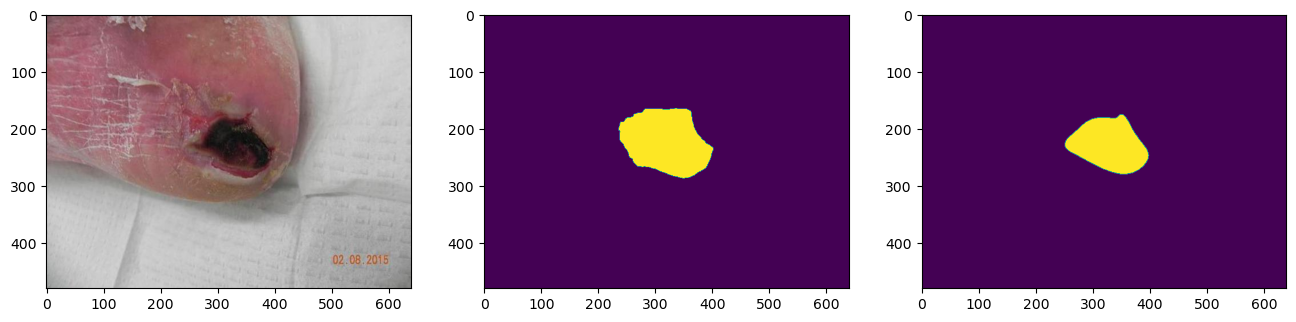

In [13]:
plots(i, model)

Loss:  tensor(0.1866, grad_fn=<RsubBackward1>)
IOU:  tensor(0.7019)


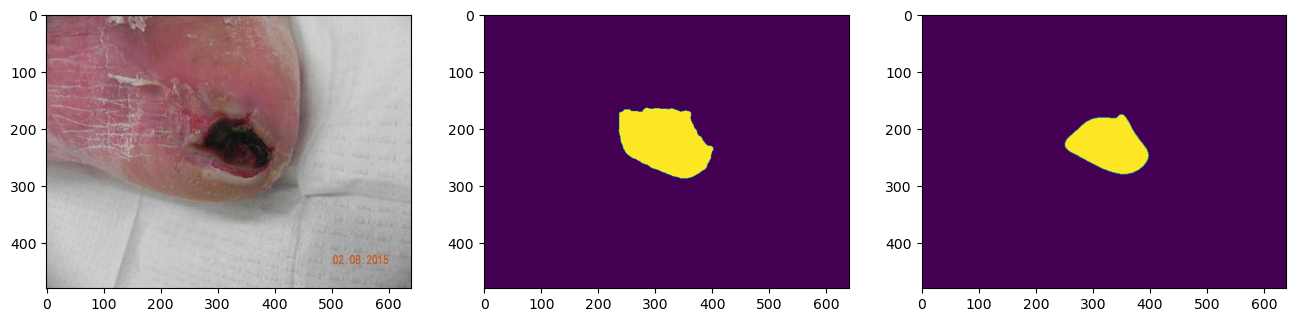

In [14]:
plots(i, baseline)

In [99]:
l, v = [], []
for i in range(0,400):
    image, label = val_ds[i]
    output = model(image.unsqueeze(0))
    l.append(loss(output, label).detach().numpy())
    v.append(IOU(output, label, 'cpu'))

In [100]:
np.mean(np.array(l))

0.3824517

In [101]:
np.mean(np.array(v))

0.5273474

## Accuracy on Small or Large Wounds

In [102]:
val_info = pd.read_csv('val_info.csv')

In [118]:
lower, upper = np.percentile(val_info['labelSize'], [5, 95])
print('Lower bound: {}, Upper bound: {}'.format(lower, upper))

smallLabel = val_info.loc[val_info['labelSize'] < lower]
largeLabel = val_info.loc[val_info['labelSize'] > upper]

iSmall = smallLabel['i'].astype('int')
iLarge = largeLabel['i'].astype('int')

l, v = [], []
for i, j in zip(range(0,len(iSmall)), iSmall):
    image, label = val_ds[j]

    output = model(image.unsqueeze(0))
    l.append(loss(output, label).detach().numpy())
    v.append(IOU(output, label, 'cpu'))

print('Small Mean Loss: ', np.mean(l))
print('Small Mean IOU: ', np.mean(v))
print(' ')

l, v = [], []
for i, j in zip(range(0,len(iLarge)), iLarge):
    image, label = val_ds[j]

    output = model(image.unsqueeze(0))
    l.append(loss(output, label).detach().numpy())
    v.append(IOU(output, label, 'cpu'))

print('Large Mean Loss: ', np.mean(l))
print('Large Mean IOU: ', np.mean(v))

Lower bound: 510.96492156982424, Upper bound: 27280.216601562424
Small Mean Loss:  0.7565507
Small Mean IOU:  0.21393614
 
Large Mean Loss:  0.26932508
Large Mean IOU:  0.6212062


In [121]:
lower, upper = np.percentile(val_info['labelSize'], [20, 80])
print('Lower bound: {}, Upper bound: {}'.format(lower, upper))

smallLabel = val_info.loc[val_info['labelSize'] < lower]
largeLabel = val_info.loc[val_info['labelSize'] > upper]

iSmall = smallLabel['i'].astype('int')
iLarge = largeLabel['i'].astype('int')

l, v = [], []
for i, j in zip(range(0,len(iSmall)), iSmall):
    image, label = val_ds[j]

    output = model(image.unsqueeze(0))
    l.append(loss(output, label).detach().numpy())
    v.append(IOU(output, label, 'cpu'))

print('Small Mean Loss: ', np.mean(l))
print('Small Mean IOU: ', np.mean(v))
print(' ')

l, v = [], []
for i, j in zip(range(0,len(iLarge)), iLarge):
    image, label = val_ds[j]

    output = model(image.unsqueeze(0))
    l.append(loss(output, label).detach().numpy())
    v.append(IOU(output, label, 'cpu'))

print('Large Mean Loss: ', np.mean(l))
print('Large Mean IOU: ', np.mean(v))

Lower bound: 1013.5811767578125, Upper bound: 9941.748046875
Small Mean Loss:  0.664032
Small Mean IOU:  0.27703142
 
Large Mean Loss:  0.19212191
Large Mean IOU:  0.7119651


In [122]:
train_info = pd.read_csv('train_info.csv')

In [123]:
lower, upper = np.percentile(train_info['labelSize'], [20, 80])
print('Lower bound: {}, Upper bound: {}'.format(lower, upper))

smallLabel = train_info.loc[train_info['labelSize'] < lower]
largeLabel = train_info.loc[train_info['labelSize'] > upper]

iSmall = smallLabel['i'].astype('int')
iLarge = largeLabel['i'].astype('int')

l, v = [], []
for i, j in zip(range(0,len(iSmall)), iSmall):
    image, label = train_ds[j]

    output = model(image.unsqueeze(0))
    l.append(loss(output, label).detach().numpy())
    v.append(IOU(output, label, 'cpu'))

print('Small Mean Loss: ', np.mean(l))
print('Small Mean IOU: ', np.mean(v))
print(' ')

l, v = [], []
for i, j in zip(range(0,len(iLarge)), iLarge):
    image, label = train_ds[j]

    output = model(image.unsqueeze(0))
    l.append(loss(output, label).detach().numpy())
    v.append(IOU(output, label, 'cpu'))

print('Large Mean Loss: ', np.mean(l))
print('Large Mean IOU: ', np.mean(v))

Lower bound: 1098.7098632812501, Upper bound: 10258.772656250003
Small Mean Loss:  0.59259015
Small Mean IOU:  0.33602795
 
Large Mean Loss:  0.109695576
Large Mean IOU:  0.8198999


## T-Test for Difference in Means

In [36]:
model_path = './models/'

model.load_state_dict(torch.load(os.path.join(model_path, 'UNet/HorizontalFlip_P=0.5_batchSize=16/model.pth'), 
                        map_location=torch.device('cpu')))

baseline = UNet()
baseline.load_state_dict(torch.load(os.path.join(model_path,  'UNet/Adam_LR_experiment/batchSize=16/LR=0.0005/model.pth'),
                            map_location=torch.device('cpu')))

<All keys matched successfully>

In [37]:
def evaluate(data, model):
    l, v = [], []
    for i, j in enumerate(data):
        image, label = j
        output = model(image)
        l.append(loss(output, label).detach().numpy())
        v.append(IOU(output, label, 'cpu'))
        
    return l, v

In [38]:
base_l, base_v = evaluate(val_iter, baseline)

In [49]:
base_v[10:20]

[tensor(0.9141),
 tensor(0.5074),
 tensor(0.9085),
 tensor(0.8404),
 tensor(0.8615),
 tensor(0.6470),
 tensor(0.9388),
 tensor(0.7697),
 tensor(0.5034),
 tensor(0.4487)]

In [40]:
np.mean(base_v)

0.4592352

In [41]:
model_l, model_v = evaluate(val_iter, model)

In [50]:
model_v[10:20]

[tensor(0.9383),
 tensor(0.8490),
 tensor(0.9100),
 tensor(0.8651),
 tensor(0.8572),
 tensor(0.5616),
 tensor(0.9492),
 tensor(0.8283),
 tensor(0.4211),
 tensor(0.5932)]

In [43]:
np.mean(model_v)

0.48092538

In [53]:
import pandas as pd
data = pd.DataFrame(columns=['baseline','model'])

In [57]:
data['baseline'] = np.array(base_v)
data['model'] = np.array(model_v)
data

,baseline,model
0,0.080706,0.049450
1,0.227740,0.222042
2,0.859060,0.790541
3,0.856882,0.838549
4,0.926457,0.929609
...,...,...
395,0.000000,0.117969
396,0.611041,0.828178
397,0.518119,0.751708
398,0.299166,0.220499


In [44]:
from scipy.stats import levene, ttest_ind, mannwhitneyu

In [58]:
levene(data['baseline'], data['model'])

LeveneResult(statistic=0.9960464436758494, pvalue=0.31857157374435874)

In [59]:
ttest_ind(data['baseline'], data['model'], alternative='less')

Ttest_indResult(statistic=-1.0526091529854924, pvalue=0.14641939113587737)